# NAME: SARAN ADHIKARI
# UNIVERSITY ID: 2329794

# WORKSHEET06

#TASK 01


In [32]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from PIL import Image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = "/content/drive/MyDrive/AI&ML/WEEK5/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI&ML/WEEK5/FruitinAmazon/FruitinAmazon/test"

In [4]:
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]


selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if images:
        selected_image = random.choice(images)
        selected_images.append((class_name, os.path.join(class_path, selected_image)))

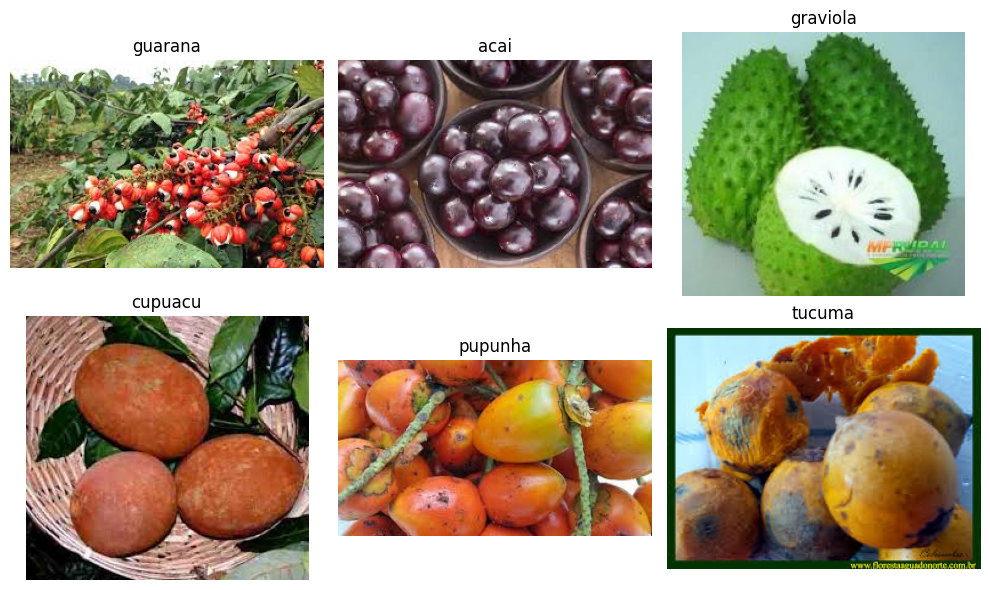

In [5]:
num_classes = len(selected_images)
cols = (num_classes + 1) // 2

fig, axes = plt.subplots(2, cols, figsize=(10, 6))
axes = axes.flatten()

for i, (class_name, image_path) in enumerate(selected_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

for i in range(len(selected_images), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
corrupted_images = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")


if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")


No corrupted images found.


In [7]:
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomContrast(0.3),
])

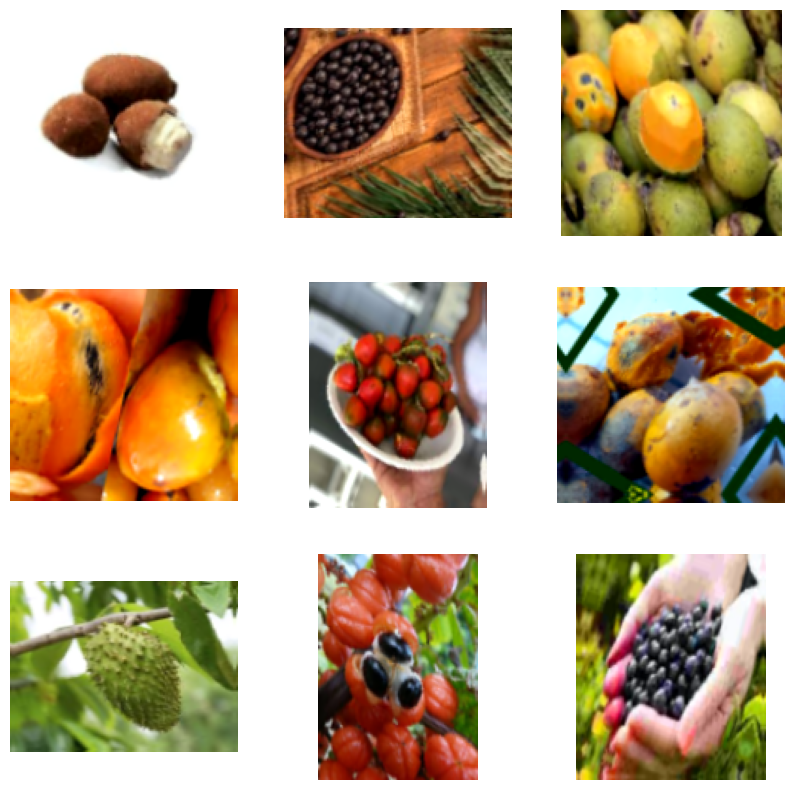

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(tf.expand_dims(images[i], axis=0), training=True)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(augmented[0], 0, 1).numpy())
        plt.axis("off")
plt.show()

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    break
input_shape = (32, 128, 128, 3)

(32, 128, 128, 3)


In [11]:
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")
layer = Dropout(rate=0.25, noise_shape=None, seed=None)

In [12]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation=None, input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),

    layers.Dense(10, activation='softmax')
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,802 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

In [13]:
inputs = keras.Input(shape=input_shape)

model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,802 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

In [23]:
checkpoint_cb = callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=15, restore_best_weights=True)

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=250,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5469 - loss: 1.2596

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.5373 - loss: 1.2481 - val_accuracy: 0.0556 - val_loss: 1.9778
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4323 - loss: 1.2263 - val_accuracy: 0.1111 - val_loss: 1.9931
Epoch 3/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5469 - loss: 0.9581

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.5373 - loss: 0.9897 - val_accuracy: 0.2222 - val_loss: 1.8936
Epoch 4/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4844 - loss: 1.1047 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.5061 - loss: 1.0864 - val_accuracy: 0.3889 - val_loss: 1.7384
Epoch 5/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5859 - loss: 0.9734

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.5846 - loss: 0.9693 - val_accuracy: 0.3333 - val_loss: 1.6992
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5074 - loss: 1.0503 - val_accuracy: 0.1111 - val_loss: 2.0305
Epoch 7/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7188 - loss: 0.6945 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.6997 - loss: 0.7377 - val_accuracy: 0.3889 - val_loss: 1.5584
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4184 - loss: 1.4004 - val_accuracy: 0.0000e+00 - val_loss: 2.2903
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5230 - loss: 1.1238 - val_accuracy: 0.0000e+00 - val_loss: 2.3906
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5768 - loss: 1.0463 - val_accuracy: 0.1667 - val_loss: 1.9114
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6788 - loss: 0.7349 - val_accuracy: 0.1667 - val_loss: 1.8465
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6220 - loss: 0.8721 - val_accuracy: 0.2222 - val_loss: 1.9032
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7587 - loss: 0.6366 - val_accuracy: 0.0556 - val_loss: 2.1191
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6241 - loss: 0.9507 - val_accuracy: 0.0000e+00 - val

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7188 - loss: 0.7259 - val_accuracy: 0.3889 - val_loss: 1.5268
Epoch 19/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7656 - loss: 0.5951 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.7578 - loss: 0.5858 - val_accuracy: 0.4444 - val_loss: 1.4772
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8464 - loss: 0.4739 - val_accuracy: 0.1111 - val_loss: 1.8088
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8255 - loss: 0.5734 - val_accuracy: 0.2222 - val_loss: 1.7433
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5629 - loss: 1.1254 - val_accuracy: 0.0000e+00 - val_loss: 4.9115
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4253 - loss: 2.5586 - val_accuracy: 0.0000e+00 - val_loss: 2.9997
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.4852 - loss: 1.4072 - val_accuracy: 0.0000e+00 - val_loss: 2.0918
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5977 - loss: 1.0292 - val_accuracy: 0.0556 - val_loss: 1.9444
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5130 - loss: 1.0993 - val_accuracy: 0.0000

In [42]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/300
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9688 - loss: 0.0736 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.9705 - loss: 0.0739 - val_accuracy: 0.8889 - val_loss: 0.2912
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9518 - loss: 0.1350 - val_accuracy: 0.8889 - val_loss: 0.3131
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9410 - loss: 0.1758 - val_accuracy: 0.8889 - val_loss: 0.3487
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9644 - loss: 0.0890 - val_accuracy: 0.8333 - val_loss: 0.6234
Epoch 5/300
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9375 - loss: 0.1567 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9271 - loss: 0.1949 - val_accuracy: 0.8889 - val_loss: 0.1547
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6628 - loss: 1.4302 - val_accuracy: 0.8889 - val_loss: 0.3574
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9223 - loss: 0.2553 - val_accuracy: 0.8889 - val_loss: 0.4174
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9440 - loss: 0.2271 - val_accuracy: 0.8889 - val_loss: 0.4099
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9891 - loss: 0.0817 - val_accuracy: 0.8889 - val_loss: 0.4379
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9301 - loss: 0.1882 - val_accuracy: 0.8889 - val_loss: 0.4325
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9822 - loss: 0.0924 - val_accuracy: 0.9444 - val_loss: 0.2161
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8928 - loss: 0.2454 - val_accuracy: 0.9444 - val_loss: 0.1978


In [43]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Loss: {train_loss:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9045 - loss: 0.3198
Loss: 0.3063
Accuracy: 0.9028


In [44]:
model.save('saved_model.h5')

loaded_model = keras.models.load_model('saved_model.h5')

train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Loss: {train_loss:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9084 - loss: 0.3089
Loss: 0.3063
Accuracy: 0.9028


In [45]:
y_true = []
y_pred = []

for images, labels in train_ds:
    y_true.extend(labels.numpy())
    predictions = loaded_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
              precision    recall  f1-score   support

     guarana       0.93      1.00      0.97        14
        acai       1.00      0.54      0.70        13
    graviola       0.92      0.92      0.92        12
     cupuacu       1.00      1.00      1.00        10
     pupunha       0.73      1.00      0.85        11
      tucuma       0.92      1.00      0.96        12

    accuracy                           0.90        72
   macro avg       0.92      0.91      0.90        72
weighted avg       0.92      0.90      0.90        72



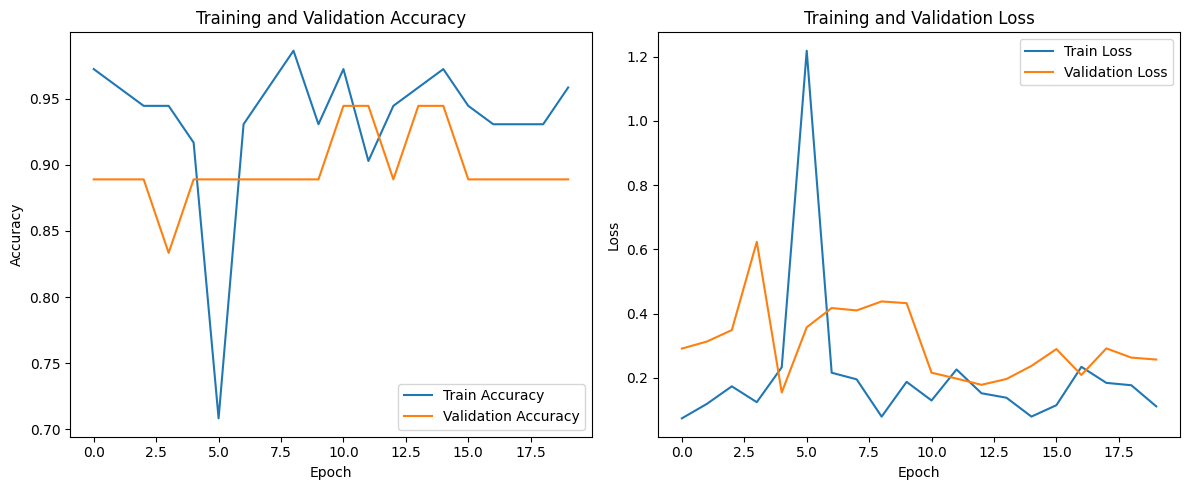

In [46]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# TASK 02

In [85]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input

In [71]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [102]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [103]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [104]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=8,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=8,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [105]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

In [106]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.1634 - loss: 5.9791 - val_accuracy: 0.4444 - val_loss: 2.4566
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5536 - loss: 1.3550 - val_accuracy: 0.5000 - val_loss: 2.0377
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8062 - loss: 0.5781 - val_accuracy: 0.6667 - val_loss: 1.7987
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9370 - loss: 0.1807 - val_accuracy: 0.6667 - val_loss: 1.6807
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0421 - val_accuracy: 0.6667 - val_loss: 1.5598
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 0.7222 - val_loss: 1.5057
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7222 - val_loss: 1.5474
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.6667 - val_loss: 1.5803

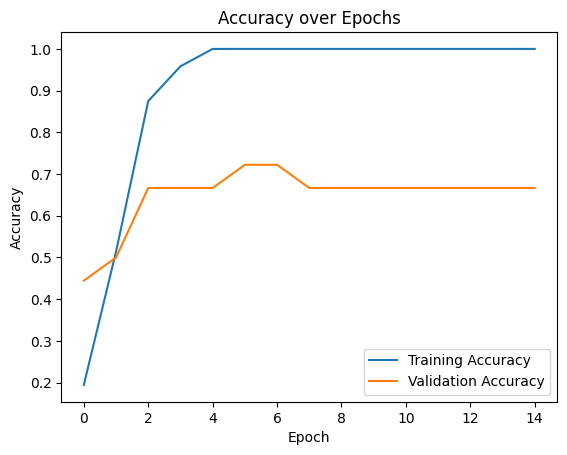

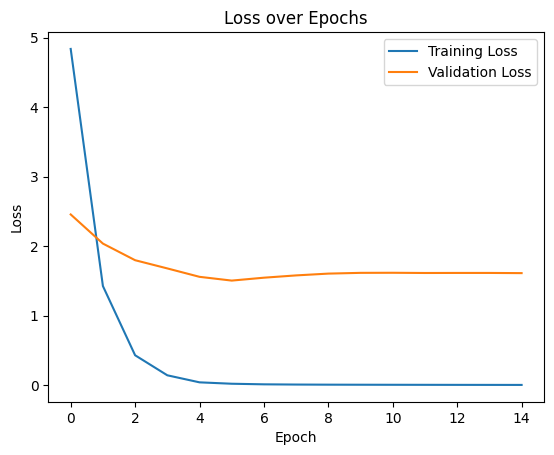

In [107]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()